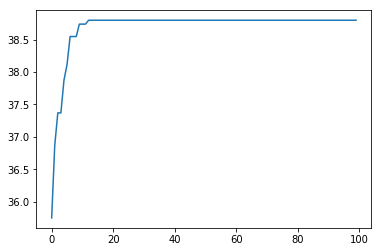

f(x1,x2) = 21.5+x1*sin(4*pi*x1)+x2*sin(20*pi*x2)
x1: 11.625588705401249
X2: 5.727210303048799
maxValue: 38.79733940671041


In [45]:
#https://www.cnblogs.com/aabbcc/p/10821435.html
#https://blog.csdn.net/hellocsz/article/details/100679506
#https://blog.csdn.net/qq_30666517/article/details/78637255
'''
本代码实现的问题是: maxf(x1,x2) = 21.5+x1*sin(4*pi*x1)+x2*sin(20*pi*x2)

-3.0<=x1<=12.1; 4.1<=x2<=5.8
'''
import numpy as np
import random
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import heapq

# 求染色体长度
def getEncodeLength(decisionvariables, delta):
    # 将每个变量的编码长度放入数组
    lengths = []
    
    for decisionvar in decisionvariables:
        uper = decisionvar[1]
        low = decisionvar[0]
        # res()返回一个数组
        res = fsolve(lambda x : ((uper - low) / delta - 2 ** x + 1), 30)
        # ceil()向上取整
        length = int(np.ceil(res[0]))
        lengths.append(length)
    return lengths

# 随机生成初始化种群
def getinitialPopulation(length, populationSize):
    chromosomes = np.zeros((populationSize, length), dtype = np.int)
    for popsize in range(populationSize):
        # np.random.randit()产生[0,2)之间的随机整数，第三个参数表示随机数的数量
        chromosomes[popsize, :] = np.random.randint(0, 2, length)
    
    return chromosomes

# 染色体解码得到表现形的解
def getDecode(population, encodelength, decisionvariables, delta):
    # 得到population中有几个元素
    populationsize = population.shape[0]
    length = len(encodelength)
    decodeVariables = np.zeros((populationsize, length), dtype = np.float)
    
    # 将染色体拆分添加到解码数组decodeVariables中
    for i, populationchild in enumerate(population):
        # 设置起始点
        start = 0
        
        for j, lengthchild in enumerate(encodelength):
            power = lengthchild - 1
            decimal = 0
            
            for k in range(start, start + lengthchild):
                # 二进制转为十进制
                decimal += populationchild[k] * (2 ** power)
                power = power - 1
                
            # 从下一个染色体开始    
            start = lengthchild
            lower = decisionvariables[j][0]
            uper = decisionvariables[j][1]
            # 转换为表现形
            decodevalue = lower + decimal * (uper - lower) / (2 ** lengthchild - 1)
            # 将解添加到数组中
            decodeVariables[i][j] = decodevalue
    
    return decodeVariables

# 得到每个个体的适应度值及累计概率
def getFitnessValue(func, decode):
    # 得到种群的规模和决策变量的个数
    popsize, decisionvar = decode.shape
    # 初始化适应度值空间
    fitnessValue = np.zeros((popsize, 1))
    for popnum in range(popsize):
        fitnessValue[popnum][0] = func(decode[popnum][0], decode[popnum][1])
    
    # 得到每个个体被选择的概率
    probability = fitnessValue / np.sum(fitnessValue)
    # 得到每个染色体被选中的累积概率，用于轮盘赌算子使用
    cum_probability = np.cumsum(probability)
    return fitnessValue, cum_probability

# 选择新的种群
def selectNewPopulation(decodepop, cum_probability):
    # 获取种群的规模
    m, n = decodepop.shape
    # 初始化新种群
    newPopulation = np.zeros((m, n))
    for i in range(m):
        # 产生一个0到1之间的随机数
        randomnum = np.random.random()
        # 轮盘赌选择
        for j in range(m):
            if (randomnum < cum_probability[j]):
                newPopulation[i] = decodepop[j]
                break
    return newPopulation

# 新种群交叉
def crossNewPopulation(newpop, prob):
    m, n = newpop.shape
    # uint8将数值转换为无符号整型
    numbers = np.uint8(m * prob)
    # 如果选择的交叉数量为奇数，则数量加1
    if numbers % 2 != 0:
        numbers = numbers + 1
      
    # 初始化新的交叉种群
    updatepopulation = np.zeros((m, n), dtype = np.uint8)
    # 随机生成需要交叉的染色体的索引号
    index = random.sample(range(m), numbers)
    # 不需要交叉的染色体直接复制到新的种群中
    for i in range(m):
        if not index.__contains__(i):
            updatepopulation[i] = newpop[i]
    # 交叉操作
    j = 0
    while j < numbers:
        # 随机生成一个交叉点，np.random.randint()返回的是一个列表
        crosspoint = np.random.randint(0, n, 1)
        crossPoint = crosspoint[0]
        
        updatepopulation[index[j]][0:crossPoint] = newpop[index[j]][0:crossPoint]
        updatepopulation[index[j]][crossPoint:] = newpop[index[j + 1]][crossPoint:]
        updatepopulation[index[j+1]][0:crossPoint] = newpop[index[j+1]][0:crossPoint]
        updatepopulation[index[j+1]][crossPoint:] = newpop[index[j]][crossPoint:]
        
        j += 2
        
    return updatepopulation

# 变异操作
def mutation(crosspopulation, mutaprob):
    # 初始化变异种群
    mutationpop = np.copy(crosspopulation)
    m, n = crosspopulation.shape
    # 计算需要变异的基因数量
    mutationnums = np.uint8(m * n * mutaprob)
    # 随机生成变异基因的位置
    mutationindex = random.sample(range(m * n), mutationnums)
    # 变异操作
    for geneindex in mutationindex:
        # np.floor()向下取整返回的是float型
        row = np.uint8(np.floor(geneindex / n))
        column = geneindex % n
        
        if mutationpop[row][column] == 0:
            mutationpop[row][column] == 1
        else:
            mutationpop[row][column] == 0
    
    return mutationpop

# 找到重新生成的种群中适应度值最大的染色体生成新种群
def findMaxPopulation(population, maxevaluation, maxSize):
    #将数组转换为列表
    maxevalue = maxevaluation.flatten()
    maxevaluelist = maxevalue.tolist()
    # 找到前100个适应度最大的染色体的索引
    maxIndex = map(maxevaluelist.index, heapq.nlargest(100, maxevaluelist))
    index = list(maxIndex)
    colume = population.shape[1]
    # 根据索引生成新的种群
    maxPopulation = np.zeros((maxSize, colume))
    i = 0
    for ind in index:
        maxPopulation[i] = population[ind]
        i = i + 1
          
    return maxPopulation

 # 适应度函数，使用lambda可以不用在函数总传递参数
def fitnessFunction():
    return lambda a, b: 21.5 + a * np.sin(4 * np.pi * a) + b * np.sin(20 * np.pi * b)

def main():
    optimalvalue = []
    optimalvariables = []
    
    # 两个决策变量的上下界，多维数组之间必须加逗号
    decisionVariables = [[-3.0, 12.1], [4.1, 5.8]]
    # 精度
    delta = 0.0001
    # 获取染色体长度
    EncodeLength = getEncodeLength(decisionVariables, delta)
    # 种群数量
    initialPopSize = 100
    # 初始生成100个种群
    population = getinitialPopulation(sum(EncodeLength), initialPopSize)
    # 最大进化代数
    maxgeneration = 100
    # 交叉概率
    prob = 0.8
    # 变异概率
    mutationprob = 0.01
    # 新生成的种群数量
    maxPopSize = 100
    
    for generation in range(maxgeneration):
        # 对种群解码得到表现形
        decode = getDecode(population, EncodeLength, decisionVariables, delta)
        # 得到适应度值和累计概率值
        evaluation, cum_proba = getFitnessValue(fitnessFunction(), decode)
        # 选择新的种群
        newpopulations = selectNewPopulation(population, cum_proba)
        # 新种群交叉
        crossPopulations = crossNewPopulation(newpopulations, prob)
        # 变异操作
        mutationpopulation = mutation(crossPopulations, mutationprob)
        # 将父母和子女合并为新的种群
        totalpopulation = np.vstack((population, mutationpopulation))
        # 最终解码
        final_decode = getDecode(totalpopulation, EncodeLength, decisionVariables, delta)
        # 适应度评估
        final_evaluation, final_cumprob = getFitnessValue(fitnessFunction(), final_decode)
        #选出适应度最大的100个重新生成种群
        population = findMaxPopulation(totalpopulation, final_evaluation, maxPopSize)
        # 找到本轮中适应度最大的值
        optimalvalue.append(np.max(final_evaluation))
        index = np.where(final_evaluation == max(final_evaluation))
        
        optimalvariables.append(list(final_decode[index[0][0]]))
    
    x = [i for i in range(maxgeneration)]
    y = [optimalvalue[i] for i in range(maxgeneration)]
    
    plt.plot(x, y)
    plt.show()
    
    optimalval = np.max(optimalvalue)

    index = np.where(optimalvalue == max(optimalvalue))
    optimalvar = optimalvariables[index[0][0]]
    #print(optimalvariables)
    #print(index[0][0])
    #print(optimalvar)
    return optimalval, optimalvar

if __name__ == "__main__":
    optval, optvar = main()
    
    print("f(x1,x2) = 21.5+x1*sin(4*pi*x1)+x2*sin(20*pi*x2)")
    print("x1:", optvar[0])
    print("X2:", optvar[1])
    print("maxValue:", optval)